<a href="https://colab.research.google.com/github/mustafabozkaya/Deep_Learning_Bootcamp/blob/master/AI/ML%20Challenge/manually_tuned_densenet201_binary_eye_classification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Name : Mustafa Bozkaya**

Binary prediction of image: male eye or female eye. Using DenseNet201.

**Download the images**

In [1]:
from google.colab import drive
drive.mount('/content/mydrive/',force_remount=True)

Mounted at /content/mydrive/


In [2]:
%pwd

'/content'

In [ ]:

!unzip "/content/mydrive/MyDrive/eye_gender_data.zip" -d "/content/datasets/"

**Summary of Libraries**

In [25]:
import zipfile
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np
from sklearn.utils import class_weight
from tensorflow.keras.applications import mobilenet_v2, Xception, NASNetLarge, NASNetMobile, DenseNet201, InceptionResNetV2
from google.colab import files
from keras import backend as K

In [26]:
from __future__ import print_function
import PIL
import PIL.Image
import tensorflow_datasets as tfds

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import glob
import numpy as np
import os
import shutil
import pathlib
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"]=(18,8)
%matplotlib inline
np.random.seed(42)

**Loading data**

In [27]:
# import zipfile, os
# local_zip = '/content/eye_gender_data.zip'
# zip_ref = zipfile.ZipFile(local_zip, 'r')
# zip_ref.extractall('/content')
# zip_ref.close()

In [28]:
train_labels = pd.read_csv("/content/datasets/eye_gender_data/Training_set.csv") 
test_labels = pd.read_csv("/content/datasets/eye_gender_data/Testing_set.csv") 
submission= pd.read_csv("/content/datasets/eye_gender_data/sample_submission.csv") 

In [29]:
train_dataset_dir=f"/content/datasets/eye_gender_data/train"

In [30]:
# Pinned this for trial-error someday, maybe
# for i in os.listdir(train_dataset_dir):
#     print(i)

In [33]:
data_dir = pathlib.Path(train_dataset_dir)
image_count = len(list(data_dir.glob('*_*.jpg')))
print(image_count)


9220


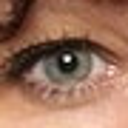

In [34]:
spec = list(data_dir.glob('*.jpg'))
img=PIL.Image.open(str(spec[9])).resize((128,128))
img

In [35]:
imgarr=np.array(img)
imgarr.shape

(128, 128, 3)

**Loading and preparing test data**

If using imagedatagenerator, photo is sorted alphabetically

Test list requirement in Testing_set.csv is sorted ascending, but not alphabetically

So the way to prepare photos is either sort test image alphabetically or loop predict based on test's csv

In [37]:
test_path = train_dataset_d=f"/content/datasets/eye_gender_data/test/"

for i in os.listdir(test_path):
  c = 14-len(i)
  os.rename(test_path + i, test_path + i[:6] + '0'*c + i[6:])

**Loading and preparing training data**

In [40]:
train_labels = pd.read_csv("/content/datasets/eye_gender_data/Training_set.csv") 
test_labels = pd.read_csv("/content/datasets/eye_gender_data/Testing_set.csv") 
submission= pd.read_csv("/content/datasets/eye_gender_data/sample_submission.csv") 

In [41]:
train_labels.head()

,filename,label
0,Image_1.jpg,male
1,Image_2.jpg,female
2,Image_3.jpg,female
3,Image_4.jpg,female
4,Image_5.jpg,male


In [42]:
test_labels.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [ ]:
female_path = img_path + 'female/'
male_path = img_path + 'male/'

In [ ]:
# Prepare to use imagedatagenerator: create two folder, male and female and distribute correctly based on Training_set.csv
if not os.path.exists(female_path):
    os.makedirs(female_path)
if not os.path.exists(male_path):
    os.makedirs(male_path)

for i,j in zip(d.filename, d.label): 
    try:
        os.rename(img_path + i, img_path + j + '/' + i)
    except:
        pass

In [ ]:
# A simple distribution check
len(os.listdir(male_path))

5058

In [ ]:
len(os.listdir(female_path))

4162

In [ ]:
z=len(os.listdir(img_path))

In [ ]:
# Apply class weight to the model later

from sklearn.utils import class_weight
import numpy as np

class_array = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(d.label.values),
    y=d.label.values)

class_weights = dict(enumerate(class_array))

In [ ]:
# 0 is female. Since female class is lesser than male, female class get weighted more
class_weights

{0: 1.1076405574243153, 1: 0.911427441676552}

In [ ]:
class_array

array([1.10764056, 0.91142744])

**Data Pre-processing (on train, validation and test data)**

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# import random
# random_number = random.randint(0, 100)
# print(random_number)

# import numpy as np
# np.random.seed(82)

# set_seed = random_number
set_seed = 82
target_img = (75,75) # Not the smallest but not the largest pixel in the data
batch = 256
# val_split = 0.02501
val_split = 0.0502 # Set fraction fold (here 461 validation image, 20% of test data)

# def grayscale_as_rgb_dim(img):
#     img = tf.image.rgb_to_grayscale(img)
#     img = tf.image.grayscale_to_rgb(img)
#     return img

test_datagen = ImageDataGenerator(
    rescale=1/255.,
    # preprocessing_function=grayscale_as_rgb_dim,
                    
    # featurewise_center=False,
    # samplewise_center=False,
    # featurewise_std_normalization=False,
    # samplewise_std_normalization=False,
    )

folder_path='eye_gender_data/'

test_generator = test_datagen.flow_from_directory(
    folder_path,
    # only read images from test directory
    classes=['test'],
    # color_mode='grayscale',
    # don't generate labels
    class_mode=None,
    shuffle=False,
    target_size=target_img
    )

datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    horizontal_flip=True,
    # vertical_flip=True,
    width_shift_range=0.125,
    height_shift_range=[-0.15, 0.05],
    # shear_range = 0.2,
    zoom_range=0.1,
    # brightness_range=[0.9,1.0],
    fill_mode = 'nearest',
    validation_split=val_split,
    # preprocessing_function=grayscale_as_rgb_dim,

    # featurewise_center=False,
    # samplewise_center=False,
    # featurewise_std_normalization=False,
    # samplewise_std_normalization=False,
    )

train_generator = datagen.flow_from_directory(
    img_path,
    target_size=target_img,
    # color_mode='grayscale',
    batch_size=batch,
    class_mode='binary',
    subset='training',
    seed=set_seed
    )

datagenval = ImageDataGenerator(
    rescale=1/255,
    validation_split=val_split,
    # preprocessing_function=grayscale_as_rgb_dim,
    
    # featurewise_center=False,
    # samplewise_center=False,
    # featurewise_std_normalization=False,
    # samplewise_std_normalization=False,
    )

validation_generator = datagenval.flow_from_directory(
    img_path,
    target_size=target_img,
    # color_mode='grayscale',
    batch_size=batch,
    class_mode='binary',
    subset='validation',
    seed=set_seed
    )

Found 2305 images belonging to 1 classes.
Found 8759 images belonging to 2 classes.
Found 461 images belonging to 2 classes.


**Building Model & Hyperparameter tuning (Manually)**

In [ ]:
from tensorflow.keras.applications import mobilenet_v2, Xception, NASNetLarge, NASNetMobile, DenseNet201, InceptionResNetV2

tf.random.set_seed(set_seed)
model = tf.keras.models.Sequential([
#   tf.keras.layers.InputLayer((*target_img,3)),
#   tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same'),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.MaxPooling2D(2, 2),
# #   # tf.keras.layers.Dropout(0.9),
#   tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.MaxPooling2D(2,2),
# #   tf.keras.layers.Dropout(0.9),
#   tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.MaxPooling2D(2,2),
# #   tf.keras.layers.Dropout(0.9),
#   tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.MaxPooling2D(2,2),
# #   tf.keras.layers.Dropout(0.9),
#   tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.MaxPooling2D(2,2),
#   # tf.keras.layers.Dropout(0.9),
#   tf.keras.layers.Conv2D(512, (3,3), activation='relu', padding='same'),
#   tf.keras.layers.BatchNormalization(),
#   tf.keras.layers.MaxPooling2D(2,2),
#   # tf.keras.layers.Dropout(0.9),
    
#   tf.keras.layers.Conv2D(1024, (3,3), activation='relu', padding='same'),
#   tf.keras.layers.MaxPooling2D(2,2),

  # InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(*target_img,3)), # Minimal must 75x75 
  DenseNet201(weights="imagenet", include_top=False, input_shape=(*target_img,3)),
  # NASNetMobile(weights="imagenet", include_top=False, input_shape=(*target_img,3)), # Must 224x224
  # NASNetLarge(weights="imagenet", include_top=False, input_shape=(*target_img,3)), # Must 224x224
  # Xception(weights="imagenet", include_top=False, input_shape=(*target_img,3)), # Minimal must 71x71 
  # mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False, input_shape=(*target_img,3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  # tf.keras.layers.Dropout(0.95),
#   tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(z-1, activation='sigmoid')
])

# model.layers[0].trainable = True

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=5e-2),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 2, 2, 1920)        18321984  
_________________________________________________________________
batch_normalization_8 (Batch (None, 2, 2, 1920)        7680      
_________________________________________________________________
flatten_4 (Flatten)          (None, 7680)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               3932672   
_________________________________________________________________
batch_normalization_9 (Batch (None, 512)               2048      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 22,264,897
Trainable params: 22,030,977
Non-trainable params: 233,920
____________________________________

In [ ]:
from keras import backend as K

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')==1):
            print("\nMaximum Validtion Accuracy has reached!")
            self.model.stop_training = True
callback = myCallback()

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'model5.h5',
    monitor = 'val_accuracy',
    save_best_only = True,
    verbose = 1
)

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor = 'val_accuracy',
#     patience = 15,
#     factor = 0.02,
#     min_lr = 1e-5,
#     # cooldown = 5,
#     verbose = 1
# )

set_callback = [
  checkpoint, 
  # reduce_lr,
  # callback,
  # early
]

**Load model**

In [ ]:
# model.load_weights('model5.h5')
# model.load_weights('check9.h5')
# print(K.eval(model.optimizer.lr)) # Print learning rate of model

**Change learning rate amid fit**

In [ ]:
# How to use: set smaller when we feel the fit begin to falls on the right minima (global)

# K.set_value(model.optimizer.learning_rate, 1e-3) # Set new learning rate for model
# print(K.eval(model.optimizer.lr))

**Validate the model**

Usually I manually run and stop amid the fit like this. This actually has been going to more than 100 epoch.

In [ ]:
history = model.fit(
      train_generator,
      epochs = 30,
      validation_data=validation_generator,
      callbacks=[set_callback],
      class_weight=class_weights,
      verbose = 1
      )

Epoch 1/50
35/35 [==============================] - 23s 655ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.1111 - val_accuracy: 0.9761

Epoch 00001: val_accuracy did not improve from 0.98698
Epoch 2/50
35/35 [==============================] - 24s 684ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0942 - val_accuracy: 0.9805

Epoch 00002: val_accuracy did not improve from 0.98698
Epoch 3/50
35/35 [==============================] - 23s 656ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.1334 - val_accuracy: 0.9740

Epoch 00003: val_accuracy did not improve from 0.98698
Epoch 4/50
35/35 [==============================] - 24s 663ms/step - loss: 0.0085 - accuracy: 0.9973 - val_loss: 0.1160 - val_accuracy: 0.9588

Epoch 00004: val_accuracy did not improve from 0.98698
Epoch 5/50
35/35 [==============================] - 24s 683ms/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 0.1298 - val_accuracy: 0.9718

Epoch 00005: val_accuracy did not improve from 0.98698
Epoch

KeyboardInterrupt: ignored

Using GPU we will never get the same result. Actually all the seed here is futile (except imagedatagenerator seed)

So in competition, when we get a good result in submission, don't forget to save

Then we can load it (architecture must be same, some imagedatagenerator properties must same)

Actually we can do without model.fit at first at all

**Make Prediction on Test Dataset and Save**

In [ ]:
preds = model.predict(test_generator)
preds;

In [ ]:
a=preds.round()
a=pd.DataFrame(a, columns=['label'])
a.label=a.label.map(lambda x: 'female' if x==0 else 'male')
a.to_csv('first.csv', index=False)
a;

In [ ]:
from google.colab import files
files.download('first.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# If manually tune, maybe we want to stop amid epoch process and want to check validation accuracy
model.evaluate(validation_generator)

**Save model and/or download locally**

In [ ]:
# model.save('check9.h5')
# files.download('check9.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# files.download('model5.h5') 